In [ ]:
using Catalyst, DifferentialEquations, Plots, Latexify, StructuralIdentifiability, ModelingToolkit, Sundials

In [ ]:

# rn = @reaction_network begin
#   (k1_f, k1_r), OF <--> IF
#   (k2_f, k2_r), OF + H_out <--> OF_Hb
#   (k3_f, k3_r), OF_Sb <--> OF + S_out
#   (k4_f, k4_r), OF_Hb <--> IF_Hb
#   (k5_f, k5_r), OF_Hb_Sb <--> OF_Hb + S_out
#   (k6_f, k6_r), IF_Sb <--> OF_Sb
#   (k7_f, k7_r), OF_Sb + H_out <--> OF_Hb_Sb
#   (k8_f, k8_r), OF_Hb_Sb <--> IF_Hb_Sb
#   (k9_f, k9_r), IF_Hb <--> IF + H_in
#   (k10_f, k10_r), IF + S_in <--> IF_Sb
#   (k11_f, k11_r), IF_Hb + S_in <--> IF_Hb_Sb
#   (k12_f, k12_r), IF_Hb_Sb <--> IF_Sb + H_in    
# end k1_f k1_r k2_f k2_r k3_f k3_r k4_f k4_r k5_f k5_r k6_f k6_r k7_f k7_r k8_f k8_r k9_f k9_r k10_f k10_r k11_f k11_r k12_f k12_r
# odesys = convert(ODESystem, rn)

function calc_flux(conc_terms, rate_terms, vol)
    IF_Hb_Sb = conc_terms[1]
    IF_Sb = conc_terms[2]
    H_in = conc_terms[3]
    rxn12_k1 = rate_terms[1]
    rxn12_k2 = rate_terms[2]
    x1 = rxn12_k1*IF_Hb_Sb
    x2 = rxn12_k2*IF_Sb.*H_in
    y_pred = vol*(x1-x2)  # returns y_pred            
end


rn2 = @reaction_network begin
  (k1_f, k1_r), OF <--> IF
  (k2_f*H_out, k2_r), OF <--> OF_Hb
  (k3_f, k3_r*S_out), OF_Sb <--> OF
  (k4_f, k4_r), OF_Hb <--> IF_Hb
  (k5_f, k5_r*S_out), OF_Hb_Sb <--> OF_Hb 
  (k6_f, k6_r), IF_Sb <--> OF_Sb
  (k7_f*H_out, k7_r), OF_Sb <--> OF_Hb_Sb
  (k8_f, k8_r), OF_Hb_Sb <--> IF_Hb_Sb
  (k9_f, k9_r), IF_Hb <--> IF + H_in
  (k10_f, k10_r), IF + S_in <--> IF_Sb
  (k11_f, k11_r), IF_Hb + S_in <--> IF_Hb_Sb
  (k12_f, k12_r), IF_Hb_Sb <--> IF_Sb + H_in    
end H_out S_out k1_f k1_r k2_f k2_r k3_f k3_r k4_f k4_r k5_f k5_r k6_f k6_r k7_f k7_r k8_f k8_r k9_f k9_r k10_f k10_r k11_f k11_r k12_f k12_r


odesys2 = convert(ODESystem, rn2)
equations(odesys2)

k_conf = 1e2
k_H_on = 1e10
k_H_off = 1e3
k_S_on = 1e7
k_S_off = 1e3

@parameters  H_out S_out k1_f k1_r k2_f k2_r k3_f k3_r k4_f k4_r k5_f k5_r k6_f k6_r k7_f k7_r k8_f k8_r k9_f k9_r k10_f k10_r k11_f k11_r k12_f k12_r
@variables t H_in(t) S_in(t) OF(t) OF_Hb(t) OF_Sb(t) OF_Hb_Sb(t) IF(t) IF_Hb(t) IF_Sb(t) IF_Hb_Sb(t)
pmap  = (H_out => 1e-7, S_out => 1e-3,
        k1_f =>0, k1_r =>0,
        k2_f =>k_H_on, k2_r =>k_H_off,
        k3_f =>k_S_off, k3_r =>k_S_on,
        k4_f =>k_conf, k4_r =>k_conf,
        k5_f =>0, k5_r =>0,
        k6_f =>k_conf, k6_r =>k_conf,
        k7_f =>0, k7_r =>0,
        k8_f =>0, k8_r =>0,
        k9_f =>0, k9_r =>0,
        k10_f =>0, k10_r =>0,
        k11_f =>k_S_on, k11_r =>k_S_off,
        k12_f =>k_H_off, k12_r =>k_H_on,
)

u0map = [H_in => 1e-7, S_in => 1e-3, 
        OF => 2.833e-8, IF => 2.125e-08, 
        OF_Hb => 2.833e-8, IF_Hb => 2.833e-8, 
        OF_Sb => 2.125e-08, IF_Sb => 2.125e-08, 
        OF_Hb_Sb => 2.125e-08, IF_Hb_Sb => 2.833e-8, 

]

tspan = (0.0,10.0)
oprob = ODEProblem(odesys2, u0map, tspan, pmap)
event_times = 5.0
condition(u,t,integrator) = t ∈ event_times
affect!(integrator) = integrator.p["H_in"] = 5e-8
cb = DiscreteCallback(condition,affect!)
#sol = solve(oprob, AutoTsit5(Rosenbrock23()), reltol=1e-16, abstol=1e-18, saveat=0.04,callback=cb, tstops=[5.0])
sol = solve(oprob, Rosenbrock23(), saveat=0.04,callback=cb, tstops=[5.0])


# event_times = [5.0,]
# condition(u,t,integrator) = t ∈ event_times
# affect!(integrator) = integrator.p[12] = 5e-8
# cb = DiscreteCallback(condition,affect!)
# sol = solve(oprob, CVODE_BDF(), saveat=0.04, abstol = 1e-16, reltol = 1e-18, callback=cb, tstops=[5.0])


# tspan = (0., 5)
# oprob = ODEProblem(odesys2, u₀map, tspan, pmap)
# sol = solve(oprob, CVODE_BDF(), reltol=1e-16, abstol=1e-18)

# calcualte flux 
# conc_terms = [sol[IF_Hb_Sb],sol[IF_Sb],sol[H_in]]
# rate_terms = [k_H_off,k_H_on]
# vol = 0.0001
# y_pred = calc_flux(conc_terms, rate_terms, vol)
# plot(y_pred)

In [ ]:
test_ode = @ODEmodel(
    OF'(t) = k1_r*IF(t)+k2_r*OF_Hb(t)+k3_f*OF_Sb(t)−k1_f*OF(t)−H_out*k2_f*OF(t)−S_out*k3_r*OF(t),
    IF'(t) = k9_f*IF_Hb(t)+k10_r*IF_Sb(t)+k1_f*OF(t)−k1_r*IF(t)−k9_r*H_in(t)*IF(t)−k10_f*IF(t)*S_in(t),
    OF_Hb'(t) = k4_r*IF_Hb(t)+k5_f*OF_Hb_Sb(t)+H_out*k2_f*OF(t)−k2_r*OF_Hb(t)−k4_f*OF_Hb(t)−S_out*k5_r*OF_Hb(t),
    OF_Sb'(t) = k6_f*IF_Sb(t)+k7_r*OF_Hb_Sb(t)+S_out*k3_r*OF(t)−k3_f*OF_Sb(t)−k6_r*OF_Sb(t)−H_out*k7_f*OF_Sb(t),
    IF_Hb'(t) = k11_r*IF_Hb_Sb(t)+k4_f*OF_Hb(t)−k4_r*IF_Hb(t)−k9_f*IF_Hb(t)+k9_r*H_in(t)*IF(t)−k11_f*IF_Hb(t)*S_in(t),
    OF_Hb_Sb'(t) = k8_r*IF_Hb_Sb(t)+S_out*k5_r*OF_Hb(t)−k5_f*OF_Hb_Sb(t)+H_out*k7_f*OF_Sb(t)−k7_r*OF_Hb_Sb(t)−k8_f*OF_Hb_Sb(t),
    IF_Sb'(t) = k12_f*IF_Hb_Sb(t)+k6_r*OF_Sb(t)−k10_r*IF_Sb(t)−k6_f*IF_Sb(t)+k10_f*IF(t)*S_in(t)−k12_r*H_in(t)*IF_Sb(t),
    IF_Hb_Sb'(t) = k8_f*OF_Hb_Sb(t)−k11_r*IF_Hb_Sb(t)−k12_f*IF_Hb_Sb(t)−k8_r*IF_Hb_Sb(t)+k12_r*H_in(t)*IF_Sb(t)+k11_f*IF_Hb(t)*S_in(t),
    H_in'(t) = k9_f*IF_Hb(t)+k12_f*IF_Hb_Sb(t)−k12_r*H_in(t)*IF_Sb(t)−k9_r*H_in(t)*IF(t),
    S_in'(t) = k10_r*IF_Sb(t)+k11_r*IF_Hb_Sb(t)−k10_f*IF(t)*S_in(t)−k11_f*IF_Hb(t)*S_in(t),
    y1(t) = H_out, 
    y2(t) = S_out, 
    y3(t) = H_in'(t)
)

@time global_id = assess_local_identifiability(test_ode,0.999, :SE)
println(global_id)



### Transporter reaction network

In [ ]:
using Catalyst, DifferentialEquations, StructuralIdentifiability, ModelingToolkit, Noise, Plots, DataFrames, CSV

# define reaction network
rn = @reaction_network begin
  (k1_f, k1_r), OF <--> IF
  (k2_f*H_out, k2_r), OF <--> OF_Hb
  (k3_f, k3_r*S_out), OF_Sb <--> OF
  (k4_f, k4_r), OF_Hb <--> IF_Hb
  (k5_f, k5_r*S_out), OF_Hb_Sb <--> OF_Hb 
  (k6_f, k6_r), IF_Sb <--> OF_Sb
  (k7_f*H_out, k7_r), OF_Sb <--> OF_Hb_Sb
  (k8_f, k8_r), OF_Hb_Sb <--> IF_Hb_Sb
  (k9_f, k9_r), IF_Hb <--> IF + H_in
  (k10_f, k10_r), IF + S_in <--> IF_Sb
  (k11_f, k11_r), IF_Hb + S_in <--> IF_Hb_Sb
  (k12_f, k12_r), IF_Hb_Sb <--> IF_Sb + H_in    
end H_out S_out k1_f k1_r k2_f k2_r k3_f k3_r k4_f k4_r k5_f k5_r k6_f k6_r k7_f k7_r k8_f k8_r k9_f k9_r k10_f k10_r k11_f k11_r k12_f k12_r

# convert reaction network to ODEsystem
odesys = convert(ODESystem, rn)

# set reference values for parameters (rate constants and external H and S concentrations)
k_conf = 1e2
k_H_on = 1e10
k_H_off = 1e3
k_S_on = 1e7
k_S_off = 1e3
H_out_ref = 1e-7
S_out_ref = 1e-3

# set parameter/variable symbols and mapping
@parameters  H_out S_out k1_f k1_r k2_f k2_r k3_f k3_r k4_f k4_r k5_f k5_r k6_f k6_r k7_f k7_r k8_f k8_r k9_f k9_r k10_f k10_r k11_f k11_r k12_f k12_r
@variables t H_in(t) S_in(t) OF(t) OF_Hb(t) OF_Sb(t) OF_Hb_Sb(t) IF(t) IF_Hb(t) IF_Sb(t) IF_Hb_Sb(t)
pmap  = [H_out => H_out_ref, S_out => S_out_ref,
        k1_f =>0, k1_r =>0,
        k2_f =>k_H_on, k2_r =>k_H_off,
        k3_f =>k_S_off, k3_r =>k_S_on,
        k4_f =>k_conf, k4_r =>k_conf,
        k5_f =>0, k5_r =>0,
        k6_f =>k_conf, k6_r =>k_conf,
        k7_f =>0, k7_r =>0,
        k8_f =>0, k8_r =>0,
        k9_f =>0, k9_r =>0,
        k10_f =>0, k10_r =>0,
        k11_f =>k_S_on, k11_r =>k_S_off,
        k12_f =>k_H_off, k12_r =>k_H_on,
]

u0map = [H_in => 1e-7, S_in => 1e-3, 
        OF => 2.833e-8, IF => 2.125e-08, 
        OF_Hb => 2.833e-8, IF_Hb => 2.833e-8, 
        OF_Sb => 2.125e-08, IF_Sb => 2.125e-08, 
        OF_Hb_Sb => 2.125e-08, IF_Hb_Sb => 2.833e-8, 

]


# create ODEproblem 
tspan = (0.0,15.0)
oprob = ODEProblem(odesys, u0map, tspan, pmap)

#testing
probSS = SteadyStateProblem(rn,u0map, p=pmap )
sol = solve(prob,SSRootfind())

# # set timed events
# event_times = [5.0,10]
# condition(u,t,integrator) = t ∈ event_times
# function affect!(integrator)
#     if integrator.t == 5.0
#         integrator.p[1] = 5e-8
#     elseif integrator.t == 10.0
#         integrator.p[1] = 1e-7
#     end
# end
# #affect!(integrator) = integrator.p[:H_out] = 5e-8 
# cb = DiscreteCallback(condition,affect!)

# # solve ODE system
# sol = solve(oprob, TRBDF2(), abstol = 1e-14, reltol = 1e-6, saveat=0.04, callback=cb, tstops=[5.0, 10.0])

# # calculate flux
# function calc_ion_flux(p,u,v)
    
#     IF_Hb_Sb_tmp 
#     IF_Sb_tmp 
#     H_in_tmp 
#     rxn12_k1_tmp1
#     rxn12_k2_tmp1 

#     x11 = rxn12_k1_tmp1*IF_Hb_Sb_tmp1
#     x21 = rxn12_k2_tmp1*IF_Sb_tmp1.*H_in_tmp1

#     y_pred = vol_tmp1*(x11-x21)
    
#     k9_f = p[1]
#     k9_r = p[2]
    
#     flux_in = v*()
#     net_flux = flux_in - flux_out         
# end
# k = [pmap[19][2], pmap[20][2], pmap[25][2], pmap[26][2]]
# c = [sol[IF_Hb], sol[H_in], sol[IF], sol[IF_Hb_Sb], sol[IF_Sb]]
# vol = 0.0001
# y_true = calc_ion_flux(k,c,vol)

# # add noise to create synthetic flux trace
# stdev_ref = 1e-13
# y_obs = add_gauss(y_true,stdev_ref)
# #plot(y_true, legend = false, ylim=[-1.5e-11,1.5e-11]);scatter!(y_obs, alpha = 0.5)

# df = DataFrame(data = y_obs)
# CSV.write("data.csv", df)
# df2 = CSV.read("data.csv", DataFrame)
# y_obs2 = df2[!, "data"]
# scatter(y_obs, alpha = 0.5, ylim=[-1.5e-11,1.5e-11])

### Sampling

In [ ]:
using Turing

Turing.setadbackend(:forwarddiff)

@model function transporter_sampler(data, oprob)
    # set priors
    stdev_sample ~ Uniform(0.5e-13 , 1.25e-13) # ~ is the tilde character
    log_k2_f ~ Uniform(6, 12)  # H on rate (1e10)
    log_k2_r ~ Uniform(-1,5)  # H off rate (1e3)
    log_k3_f ~ Uniform(-1,5)  # S off rate (1e3)
    log_k3_r ~ Uniform(3,9)  # S on rate (1e7)
    log_k4_f ~ Uniform(-2,4)  # conf rate (1e2)
    log_k4_r ~ Uniform(-2,4)   # conf rate (1e2)
    log_k6_f ~ Uniform(-2,4)   # conf rate (1e2)
    log_k6_r ~ Uniform(-2,4)   # conf rate (1e2)
    log_k11_f ~ Uniform(3,9) # S on rate (1e7)
    log_k11_r ~ Uniform(-1,5)  # S off rate (1e3)
    log_k12_f ~ Uniform(-1,5)  # H off rate (1e3)
    log_k12_r = (log_k2_f+log_k3_f+log_k4_f+log_k6_f+log_k11_f+log_k12_f)-(log_k2_r+log_k3_r+log_k4_r+log_k6_r+log_k11_r)
     
    # set parameter values
    pmap1 = [H_out => H_out_ref, S_out => S_out_ref,
            k1_f =>0.0, k1_r =>0.0,
            k2_f =>10.0^log_k2_f, k2_r =>10.0^log_k2_r,
            k3_f =>10.0^log_k3_f, k3_r =>10.0^log_k3_r,
            k4_f =>10.0^log_k4_f, k4_r =>10.0^log_k4_r,
            k5_f =>0.0, k5_r =>0.0,
            k6_f =>10.0^log_k6_f, k6_r =>10.0^log_k6_r,
            k7_f =>0.0, k7_r =>0.0,
            k8_f =>0.0, k8_r =>0.0,
            k9_f =>0.0, k9_r =>0.0,
            k10_f =>0.0, k10_r =>0.0,
            k11_f =>10.0^log_k11_f, k11_r =>10.0^log_k11_r,
            k12_f =>10.0^log_k12_f, k12_r =>10.0^log_k12_r,
    ]

    # create ODEproblem (same u0map and tspan as synthetic model)
    oprob1 = ODEProblem(odesys, u0map, tspan, pmap1)

    # set timed events
    event_times = [5.0,10]
    condition(u,t,integrator) = t ∈ event_times
    function affect!(integrator)
        if integrator.t == 5.0
            integrator.p[1] = 5e-8
        elseif integrator.t == 10.0
            integrator.p[1] = 1e-7
        end
    end
    cb = DiscreteCallback(condition,affect!)

    # solve ODE system
    sol1 = solve(oprob1, TRBDF2(), abstol = 1e-14, reltol = 1e-6, saveat=0.04, progress=false, callback=cb, tstops=[5.0, 10.0])

    # calc flux
    k1 = [pmap1[19][2], pmap1[20][2], pmap1[25][2], pmap1[26][2]]
    c1 = [sol1[IF_Hb], sol1[H_in], sol1[IF], sol1[IF_Hb_Sb], sol1[IF_Sb]]
    vol1 = 0.0001
    y_pred = calc_ion_flux(k1,c1,vol1)
    
    for i = 1:length(y_pred)
        data[i] ~ Normal(y_pred[i], stdev_sample)
    end
    
end

model = transporter_sampler(y_obs, oprob)

c = sample(model, NUTS(10000, .65),10000);

In [ ]:
c[:stdev_sample]

In [ ]:
c

In [ ]:
using StatsPlots
plot(c)

# 1:1 transporter - single cycle model

#### load and plot data

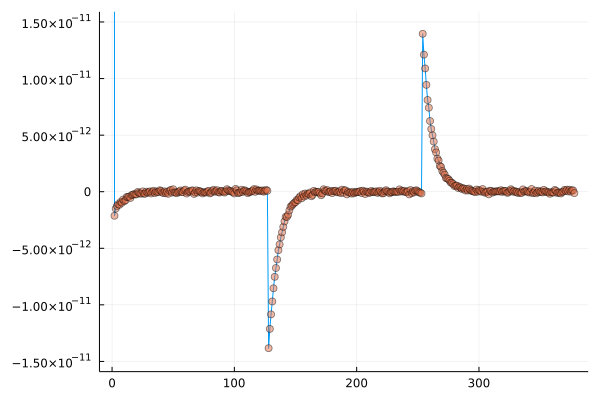

In [1]:
using Plots, DataFrames, CSV 

# load and plot data
df = CSV.read("data.csv", DataFrame)
y_obs = df[!, "data"]
plot(y_obs, legend = false, ylim=[-1.5e-11,1.5e-11]) ;scatter!(y_obs, legend = false, alpha = 0.5, ylim=[-1.5e-11,1.5e-11])

#### build catalyst model

In [ ]:
using Catalyst, DifferentialEquations, StatsPlots, Plots, DataFrames, CSV, Random, Turing, Latexify, ModelingToolkit, DynamicHMC
using ModelingToolkit: varmap_to_vars
Random.seed!(14)

# load flux dataset fo ~ 300 data points
df = CSV.read("data_1c.csv", DataFrame) 
y_obs = df[!, "data"]

# flux calculation function
function calc_flux(p,u,v)
    flux_in = v*(p[1]*u[1])
    flux_out = v*(p[2]*u[2].*u[3])
    net_flux = flux_in - flux_out         
end

# define reaction network in Catalyst
rn = @reaction_network begin
  (k1_f*H_out, k1_r), OF <--> OF_Hb
  (k2_f, k2_r), OF_Hb <--> IF_Hb
  (k3_f, k3_r), IF_Hb + S_in <--> IF_Hb_Sb
  (k4_f, k4_r), IF_Hb_Sb <--> IF_Sb + H_in
  (k5_f, k5_r), IF_Sb <--> OF_Sb
  (k6_f, k6_r*S_out), OF_Sb <--> OF
end H_out S_out k1_f k1_r k2_f k2_r k3_f k3_r k4_f k4_r k5_f k5_r k6_f k6_r
@parameters  H_out S_out k1_f k1_r k2_f k2_r k3_f k3_r k4_f k4_r k5_f k5_r k6_f k6_r 
@variables t H_in(t) S_in(t) OF(t) OF_Hb(t) IF_Hb(t) IF_Hb_Sb(t) IF_Sb(t) OF_Sb(t)
u0map = [H_in => 1e-7, S_in => 1e-3, 
        OF => 2.833e-8, OF_Hb => 2.833e-8,  
        IF_Hb => 2.833e-8, IF_Hb_Sb => 2.833e-8,
        IF_Sb => 2.125e-8, OF_Sb => 2.125e-8, 
        ]
H_out_ref = 1e-7
S_out_ref = 1e-3
pmap = [H_out => H_out_ref, S_out => S_out_ref,
        k1_f =>1e10, k1_r =>1e3,
        k2_f =>1e2, k2_r =>1e2,
        k3_f =>1e7, k3_r =>1e3,
        k4_f =>1e3, k4_r =>1e10,
        k5_f =>1e2, k5_r =>1e2,
        k6_f =>1e3, k6_r =>1e7
        ]

# convert reaction network to ODEsystem
odesys = convert(ODESystem, rn)
latexify(odesys)


# create ODEproblem w/ timed events discrete callback
tspan1 = (0.0,15.0)
oprob = ODEProblem(odesys, u0map, tspan1, pmap)
event_times = [5.0,10]
condition(u,t,integrator) = t ∈ event_times
function affect!(integrator)
    if integrator.t == 5.0
        integrator.p[1] = 5e-8
    elseif integrator.t == 10.0
        integrator.p[1] = 1e-7
    end
end
cb = DiscreteCallback(condition,affect!)

# create Turing model w/ forward differentiation
Turing.setadbackend(:forwarddiff)
@model function rxn_sampler(data, prob, sys)
    
    # set priors
    stdev_sample ~ Uniform(0.5e-13 , 1.25e-13) 
    log_k1_f ~ Uniform(6, 12)  # log10 rate constant (ref=1e10)
    log_k1_r ~ Uniform(-1,5)  # log10 rate constant (ref=1e3)  
    log_k2_f ~ Uniform(-2,4)  # log10 rate constant (ref=1e2)
    log_k2_r ~ Uniform(-2,4)  # log10 rate constant (ref=1e2)
    log_k3_f ~ Uniform(3,9)  # log10 rate constant (ref=1e7) 
    log_k3_r ~ Uniform(-1,5)  # log10 rate constant (ref=1e3)  
    log_k4_f ~ Uniform(-1,5)  # log10 rate constant (ref=1e3) 
    log_k4_r ~ Uniform(6, 12)  # log10 rate constant (ref=1e10)
    log_k5_f ~ Uniform(-2,4)  # log10 rate constant (ref=1e2)
    log_k5_r ~ Uniform(-2,4)   # log10 rate constant (ref=1e2)
    log_k6_f ~ Uniform(-1,5)  # log10  rate constant (ref=1e3)
    # set parameter values and initial concentrations
    log_k6_r = (log_k1_f+log_k2_f+log_k3_f+log_k4_f+log_k5_f+log_k6_f)-(log_k1_r+log_k2_r+log_k3_r+log_k4_r+log_k5_r)
    
    pmap1 = [H_out => H_out_ref, S_out => S_out_ref,
            k1_f =>10.0^log_k1_f, k1_r =>10.0^log_k1_r,
            k2_f =>10.0^log_k2_f, k2_r =>10.0^log_k2_r,
            k3_f =>10.0^log_k3_f, k3_r =>10.0^log_k3_r,
            k4_f =>10.0^log_k4_f, k4_r =>10.0^log_k4_r,
            k5_f =>10.0^log_k5_f, k5_r =>10.0^log_k5_f,
            k6_f =>10.0^log_k6_f, k6_r =>10.0^log_k6_r,
    ]
    pnew = varmap_to_vars(pmap1, parameters(sys))
    
    oprob1 = remake(prob, p=pnew)
    sol = solve(oprob1, TRBDF2(), abstol = 1e-14, reltol = 1e-9, saveat=0.04, callback=cb, tstops=[5.0, 10.0])
    
    # calc flux (y_pred)
    k = [pmap1[9][2], pmap1[10][2]]
    c = [sol[IF_Hb_Sb], sol[H_in], sol[IF_Sb]]
    vol = 0.0001
    y_pred = calc_flux(k,c,vol)
      
    for i = 1:length(y_pred)
        data[i] ~ Normal(y_pred[i], stdev_sample)
    end    
end
model = rxn_sampler(y_obs, oprob, odesys)

# run single-chain No-U-Turn sampler 
#c = sample(model, NUTS(.65),10000)
#c = sample(model, DynamicNUTS(), MCMCThreads(), 10000, 4, progress=true)
#chain = mapreduce(c -> sample(model, DynamicNUTS() ,10000), chainscat, 1:3)

iterations = 10_000_000
c = sample(model, MH(), iterations)

Sampling:  73%|█████████████████████████████▉           |  ETA: 1 days, 1:38:07

In [ ]:
p = plot(c)

In [ ]:
savefig(p,"file.png")

In [ ]:
c["stdev_sample"]